In [1]:
import torch
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

torch.__version__

'2.4.0+cu121'

## Data (it ain't real, but who cares)

In [2]:
m_samples = 1_000

X, y = datasets.make_circles(m_samples,
                    noise=0.04,
                    random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

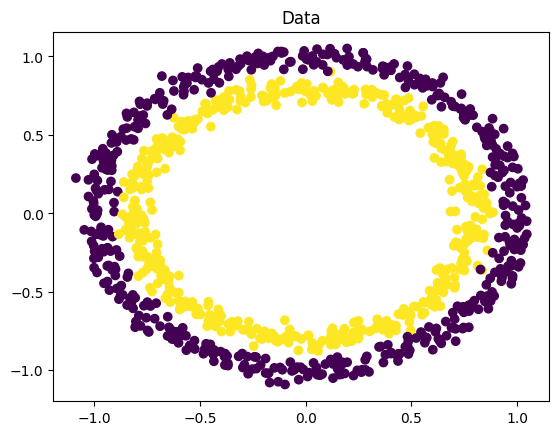

In [3]:
plt.title("Data")
plt.scatter(X[:, 0], X[:, 1], c=y);

In [4]:
val_count = np.bincount(y)
li = np.nonzero(val_count)[0]
list(zip(li, val_count[li]))  # classes are balanced

[(0, 500), (1, 500)]

In [5]:
# Convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))